In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import skimage.io as io
from skimage import feature
from skimage.transform import resize
from sklearn.feature_selection import VarianceThreshold
from skimage.color import rgb2gray
from sklearn.decomposition import PCA
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from skimage.filters import gabor
from skimage.feature import corner_fast, corner_peaks, corner_harris
import sys
import os
sys.path.append('../')
import helpers.histogram_classifier as hc

In [2]:
def sub_grid(image, size=32):
    """
    Split an image into a grid of non-overlapping square boxes, and return each box in turn
    :params image: image as numpy array
    :params size: side-length of box to use; should be a power of 2
    :return: yields each box in turn
    """
    pic_size = image.shape
    box_side = size
    for x in range(0, pic_size[0], box_side):
        for y in range(0, pic_size[1], box_side):
            yield image[x:x + box_side, y:y + box_side, :]

In [3]:
from IPython.core.display import HTML
css = open('styles/table-style.css').read() #+ open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [4]:
def get_image_features(img, box_size):
    """
    Get RGB and edge features for a single image by splitting the image into a grid of non-overlapping
    square boxes, and obtaining features for each box
    :params img: image as a numpy array
    :params box_size: the side-length in pixels of the box to be used
    :return: mean Red pixel value in each box
    :return: mean Green pixel value in each box
    :return: mean Blue pixel value in each box
    :return: number of edges in each box, extracted using skimage canny edges algorithm
    """
    image_features = []
    for box in sub_grid(img, size=box_size):
        features = []
        features.append(np.mean(box[:, :, 0]))
        features.append(np.mean(box[:, :, 1]))
        features.append(np.mean(box[:, :, 2]))
        features.append(np.sum(feature.canny(rgb2gray(box), sigma=1)))
        image_features.append(np.array(features))
    image_features = np.array(image_features)
    return image_features[:, 0], image_features[:, 1], image_features[:, 2], image_features[:, 3]

In [5]:
def get_complete_features(image_classes, image_names, box_size):
    """
    Get RGB and edge features for a dictionary of image names
    :params image_classes: list of n image classes
    :params image_names: dictionary of m image names for each class
    :params size: size as tuple for reshaping images for extracting edges and corners
    :return: red_features: average red pixel value for each box in each image
    :return: green_features: average green pixel value for each box in each image
    :return: blue_features: average blue pixel value for each box in each image
    :return: edge_features: number of edges detected for each box in each image
    :return: labels: array of true labels for each image
    """
    red_features = []
    green_features = []
    blue_features = []
    edge_features = []
    labels = []
    for c in image_classes:
        for i in image_names[c]:
            img = io.imread(os.path.join("../data/food-101/top_classes/", c, "", i))
            red, green, blue, edge = get_image_features(img, box_size=box_size)
            red_features.append(red)
            green_features.append(green)
            blue_features.append(blue)
            edge_features.append(edge)
            labels.append(c)
    
    return np.array(red_features), np.array(green_features), np.array(blue_features), np.array(edge_features), np.array(labels)

In [6]:
PCA_components = 256
BOX = 16

In [7]:
classes = pd.read_csv('../data/food-101/meta/top_classes.csv', index_col=0)
class_list = list(classes['class'].unique())

image_names = {}
for c in class_list:
    image_names[c] = np.array(classes[classes['class'] == c]['name'])

In [8]:
train, test = hc.split_data(image_names, 0.75)

In [10]:
#Get complete histogram features, edge and corners
all_red_features, all_green_features, all_blue_features, all_edge_features, train_labels = get_complete_features(class_list, train, BOX)

In [11]:
#Get top features using PCA for red features
if all_red_features.shape[1] > PCA_components:
    red_pca = PCA(n_components=PCA_components)
    red_pca.fit(all_red_features)
    final_red_features = red_pca.transform(all_red_features)
else:
    final_red_features = all_red_features

In [12]:
#Get top features using PCA for green features
if all_green_features.shape[1] > PCA_components:
    green_pca = PCA(n_components=PCA_components)
    green_pca.fit(all_green_features)
    final_green_features = green_pca.transform(all_green_features)
else:
    final_green_features = all_green_features

In [13]:
#Get top features using PCA for blue features
if all_blue_features.shape[1] > PCA_components:
    blue_pca = PCA(n_components=PCA_components)
    blue_pca.fit(all_blue_features)
    final_blue_features = blue_pca.transform(all_blue_features)
else:
    final_blue_features = all_blue_features

In [14]:
#Get top features using PCA for edge features
if all_edge_features.shape[1] > PCA_components:
    edge_pca = PCA(n_components=PCA_components)
    edge_pca.fit(all_edge_features)
    final_edge_features = edge_pca.transform(all_edge_features)
else:
    final_edge_features = all_edge_features

In [15]:
all_features = np.concatenate((final_red_features, final_green_features, final_blue_features, final_edge_features), axis=1)

In [16]:
#Setup grid-search for top parameters
depth = np.array([8, 10, 12, 14])
estimators = np.array([10, 25, 50, 100, 250, 500])
model = RandomForestClassifier()
grid = GridSearchCV(estimator=model, param_grid=dict(n_estimators=estimators, max_depth=depth))

In [17]:
grid.fit(all_features, train_labels)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': array([ 8, 10, 12, 14]), 'n_estimators': array([ 10,  25,  50, 100, 250, 500])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [18]:
print("Best score = {}".format(grid.best_score_))
print("N_estimators: {}".format(grid.best_estimator_.n_estimators))
print("Max depth: {}".format(grid.best_estimator_.max_depth))

Best score = 0.2591111111111111
N_estimators: 500
Max depth: 10


In [19]:
%%time
rf = RandomForestClassifier(n_estimators=grid.best_estimator_.n_estimators, max_depth=grid.best_estimator_.max_depth)
rf.fit(all_features, train_labels)

CPU times: user 1min 41s, sys: 141 ms, total: 1min 41s
Wall time: 1min 41s


In [20]:
#Get Test Features
all_red_features_t, all_green_features_t, all_blue_features_t, all_edge_features_t, test_labels = get_complete_features(class_list, test, BOX)

In [21]:
if all_red_features_t.shape[1] > PCA_components:
    final_red_t = red_pca.transform(all_red_features_t)
else:
    final_red_t = all_red_features_t

if all_green_features_t.shape[1] > PCA_components:
    final_green_t = green_pca.transform(all_green_features_t)
else:
    final_green_t = all_green_features_t
    
if all_blue_features_t.shape[1] > PCA_components:
    final_blue_t = blue_pca.transform(all_blue_features_t)
else:
    final_blue_t = all_blue_features_t

if all_edge_features_t.shape[1] > PCA_components:
    final_edge_t = edge_pca.transform(all_edge_features_t)
else:
    final_edge_t = all_edge_features_t

In [22]:
final_test_features = np.concatenate((final_red_t, final_green_t, final_blue_t, final_edge_t), axis=1)

In [23]:
%%time
predicted_labels = rf.predict(final_test_features)

CPU times: user 622 ms, sys: 61 ms, total: 683 ms
Wall time: 456 ms


In [24]:
%%time
predicted_probabilities = rf.predict_proba(final_test_features)

CPU times: user 407 ms, sys: 60.6 ms, total: 467 ms
Wall time: 466 ms


In [25]:
overall, metrics, confusion = hc.get_metrics(test_labels, predicted_labels, class_list)

In [26]:
overall

,Accuracy,F1,Precision,Recall
Results,0.253,0.23,0.246,0.253


In [27]:
metrics

,Precision,Recall,F1-Score,Support
pork_chop,0.24,0.29,0.26,250.0
lasagna,0.29,0.14,0.19,250.0
french_toast,0.23,0.22,0.23,250.0
guacamole,0.26,0.32,0.28,250.0
apple_pie,0.19,0.05,0.08,250.0
cheesecake,0.27,0.50,0.35,250.0
hamburger,0.28,0.07,0.11,250.0
fried_rice,0.27,0.36,0.31,250.0
carrot_cake,0.15,0.08,0.10,250.0
chocolate_cake,0.28,0.30,0.29,250.0


In [28]:
confusion

,pork_chop,lasagna,french_toast,guacamole,apple_pie,cheesecake,hamburger,fried_rice,carrot_cake,chocolate_cake,steak,pizza
pork_chop,72,6,20,9,6,14,8,12,10,30,36,27
lasagna,35,36,20,14,6,26,4,34,8,4,11,52
french_toast,23,11,55,22,7,16,5,26,11,8,15,51
guacamole,13,2,11,79,3,22,4,31,11,10,10,54
apple_pie,10,15,20,29,13,62,5,28,16,15,6,31
cheesecake,7,5,9,17,6,124,3,9,10,41,4,15
hamburger,24,6,20,21,7,35,18,24,9,19,19,48
fried_rice,14,15,10,27,9,17,6,90,3,1,5,53
carrot_cake,21,8,23,20,6,66,3,18,19,25,11,30
chocolate_cake,23,2,15,17,0,46,3,6,16,76,37,9


In [29]:
plt.style.use('ggplot')

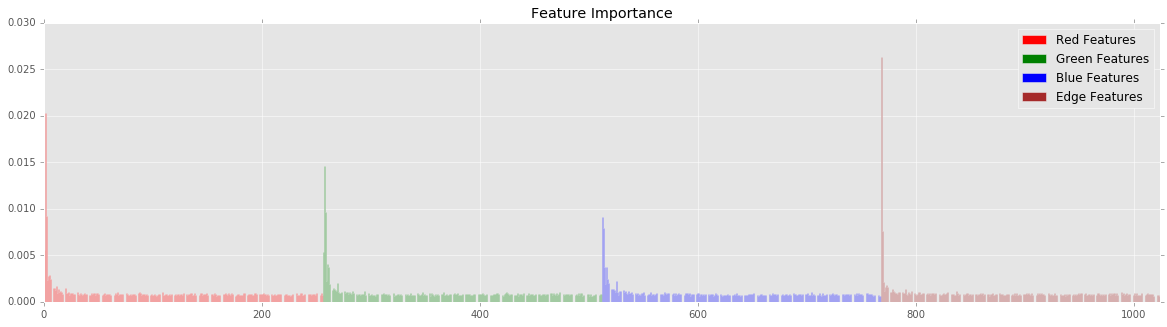

In [33]:
fig, ax = plt.subplots(figsize=(20,5))

num_red = final_red_features.shape[1]
num_green = final_green_features.shape[1]
num_blue = final_blue_features.shape[1]
num_edges = final_edge_features.shape[1]
x = [num_red, num_red + num_green, num_red + num_green + num_blue, num_red + num_green + num_blue + num_edges]
ax.bar([i for i in range(x[0])], rf.feature_importances_[:x[0]], color='red', label='Red Features')
ax.bar([i for i in range(x[0], x[1])], rf.feature_importances_[x[0]:x[1]], color='green', label='Green Features')
ax.bar([i for i in range(x[1], x[2])], rf.feature_importances_[x[1]:x[2]], color='blue', label='Blue Features')
ax.bar([i for i in range(x[2], x[3])], rf.feature_importances_[x[2]:x[3]], color='brown', label='Edge Features')
ax.set_title("Feature Importance")
ax.set_xlim(0,x[3])
ax.legend()
plt.show()

In [34]:
PCA_components = 30

In [35]:
red_pca = PCA(n_components=PCA_components)
red_pca.fit(final_red_features)
reduced_red_features = red_pca.transform(final_red_features)

In [37]:
green_pca = PCA(n_components=PCA_components)
green_pca.fit(final_green_features)
reduced_green_features = green_pca.transform(final_green_features)

In [38]:
blue_pca = PCA(n_components=PCA_components)
blue_pca.fit(final_blue_features)
reduced_blue_features = blue_pca.transform(final_blue_features)

In [39]:
edge_pca = PCA(n_components=PCA_components)
edge_pca.fit(final_edge_features)
reduced_edge_features = edge_pca.transform(final_edge_features)

In [40]:
reduced_features = np.concatenate((reduced_red_features, reduced_green_features, reduced_blue_features, reduced_edge_features), axis=1)

In [41]:
#Setup grid-search for top parameters
depth = np.array([8, 10, 12, 14])
estimators = np.array([10, 25, 50, 100, 250, 500])
model = RandomForestClassifier()
grid = GridSearchCV(estimator=model, param_grid=dict(n_estimators=estimators, max_depth=depth))

In [42]:
grid.fit(reduced_features, train_labels)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': array([ 8, 10, 12, 14]), 'n_estimators': array([ 10,  25,  50, 100, 250, 500])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [43]:
print("Best score = {}".format(grid.best_score_))
print("N_estimators: {}".format(grid.best_estimator_.n_estimators))
print("Max depth: {}".format(grid.best_estimator_.max_depth))

Best score = 0.291
N_estimators: 250
Max depth: 14


In [45]:
%%time
rf = RandomForestClassifier(n_estimators=grid.best_estimator_.n_estimators, max_depth=grid.best_estimator_.max_depth)
rf.fit(reduced_features, train_labels)

CPU times: user 21.1 s, sys: 192 ms, total: 21.2 s
Wall time: 21.4 s


In [46]:
reduced_red_t = red_pca.transform(final_red_t)
reduced_green_t = green_pca.transform(final_green_t)
reduced_blue_t = blue_pca.transform(final_blue_t)
reduced_edge_t = edge_pca.transform(final_edge_t)

In [47]:
final_test_features = np.concatenate((reduced_red_t, reduced_green_t, reduced_blue_t, reduced_edge_t), axis=1)

In [48]:
%%time
predicted_labels = rf.predict(final_test_features)

CPU times: user 221 ms, sys: 44.5 ms, total: 266 ms
Wall time: 267 ms


In [49]:
%%time
predicted_probabilities = rf.predict_proba(final_test_features)

CPU times: user 210 ms, sys: 35.3 ms, total: 246 ms
Wall time: 247 ms


In [50]:
overall, metrics, confusion = hc.get_metrics(test_labels, predicted_labels, class_list)

In [51]:
overall

,Accuracy,F1,Precision,Recall
Results,0.282,0.268,0.274,0.282


In [52]:
metrics

,Precision,Recall,F1-Score,Support
pork_chop,0.31,0.30,0.31,250.0
lasagna,0.27,0.18,0.22,250.0
french_toast,0.26,0.22,0.24,250.0
guacamole,0.28,0.33,0.31,250.0
apple_pie,0.20,0.09,0.13,250.0
cheesecake,0.29,0.48,0.36,250.0
hamburger,0.26,0.21,0.23,250.0
fried_rice,0.30,0.36,0.33,250.0
carrot_cake,0.24,0.14,0.18,250.0
chocolate_cake,0.33,0.31,0.32,250.0


In [53]:
confusion

,pork_chop,lasagna,french_toast,guacamole,apple_pie,cheesecake,hamburger,fried_rice,carrot_cake,chocolate_cake,steak,pizza
pork_chop,75,11,13,13,8,9,15,17,9,26,31,23
lasagna,20,46,26,13,7,25,11,30,9,5,10,48
french_toast,23,24,55,24,13,15,13,16,9,6,9,43
guacamole,5,6,15,83,5,23,21,27,10,3,8,44
apple_pie,5,17,19,26,23,53,16,22,17,12,14,26
cheesecake,7,7,5,8,13,120,15,10,10,31,8,16
hamburger,12,8,14,22,13,28,52,25,8,17,13,38
fried_rice,10,10,11,29,8,21,8,90,6,2,4,51
carrot_cake,17,10,12,20,15,55,11,18,36,19,11,26
chocolate_cake,15,5,13,20,1,37,12,7,22,77,33,8


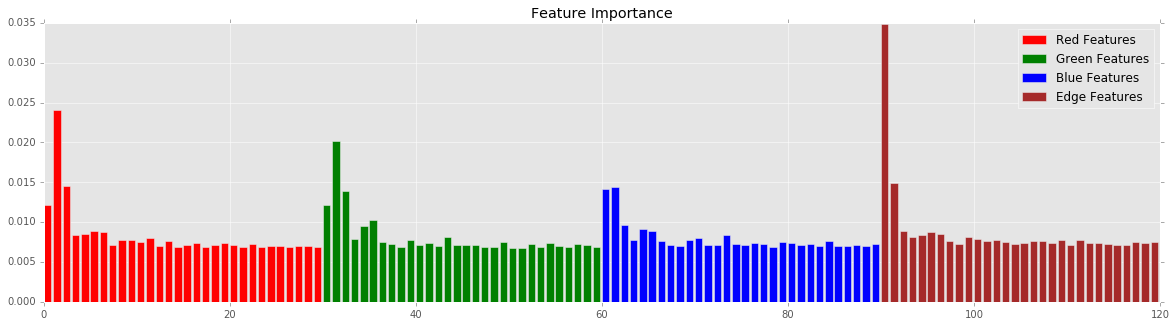

In [54]:
fig, ax = plt.subplots(figsize=(20,5))

num_red = reduced_red_features.shape[1]
num_green = reduced_green_features.shape[1]
num_blue = reduced_blue_features.shape[1]
num_edges = reduced_edge_features.shape[1]
x = [num_red, num_red + num_green, num_red + num_green + num_blue, num_red + num_green + num_blue + num_edges]
ax.bar([i for i in range(x[0])], rf.feature_importances_[:x[0]], color='red', label='Red Features')
ax.bar([i for i in range(x[0], x[1])], rf.feature_importances_[x[0]:x[1]], color='green', label='Green Features')
ax.bar([i for i in range(x[1], x[2])], rf.feature_importances_[x[1]:x[2]], color='blue', label='Blue Features')
ax.bar([i for i in range(x[2], x[3])], rf.feature_importances_[x[2]:x[3]], color='brown', label='Edge Features')
ax.set_title("Feature Importance")
ax.set_xlim(0,x[3])
ax.legend()
plt.show()